This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2026.1_tutorials/wallaroo-run-anywhere/inference-on-any-architecture/power10/computer-vision-resnet-power10).

## Run Anywhere:  Deploy and Publish Computer Vision Model Resnet50 for IBM Power10

The following tutorial demonstrates how to use a trained computer vision Resnet50 model and deploy in Wallaroo for inferencing on IBM Power10.  The model is in ONNX format, easily portable between different architectures without any additional special libraries.

The same model is then published and made available for deployment on edge and multi-cloud devices on the IBM Power10 architecture.

For access to these sample models and for a demonstration:

* Contact your Wallaroo Support Representative **OR**
* [Schedule Your Wallaroo.AI Demo Today](https://wallaroo.ai/request-a-demo/)

Deploying on IBM Power10 is made easy with Wallaroo.  Models are defined with an **architecture** at the upload stage, allowing the deployment of the same model on different architectures.

## Tutorial Overview

This tutorial demonstrates using Wallaroo to:

* Upload a model and define the deployment architecture as `Power10`.
* Deploy the model on a node with the Power10 chips and perform a sample inference.
* Publish the model to an OCI registry for deployment on edge and multi-cloud environments with Power10 chips.

## Requirements

The following tutorial requires the following:

* Wallaroo version 2024.4 and above.
* At least one Power10 node deployed in the cluster.

This process will use the following steps:

1. Upload the model to Wallaroo with the architecture set to `Power10`.
1. Deploy the model on Power10 nodes and perform sample computer vision detection inferences.
1. Publish the model to an OCI (Open Container Initiative) Registry for deployment on edge and multi-cloud environments.

## Steps

### Import Libraries

The first step will be to import our libraries.  Please check with **Step 00: Introduction and Setup** and verify that the necessary libraries and applications are added to your environment.

In [2]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from wallaroo.engine_config import Architecture
from IPython.display import display
from IPython.display import Image
import pandas as pd
import json
import datetime
import time
#import cv2
import matplotlib.pyplot as plt
import string
import random
import pyarrow as pa
import sys
import asyncio
pd.set_option('display.max_colwidth', None)

import sys

import utils



### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [ ]:
# Login through local service

wl = wallaroo.Client()

### Set Variables

The following variables and methods are used later to create or connect to an existing workspace, pipeline, and model.  This example has both the resnet model, and a post process script.

In [6]:
workspace_name = f'resnetworkspace'
pipeline_name = f'resnetnetpipeline-benchp10'
model_name = f'resnet50p10bench'
model_file_name = 'models/frcnn-resnet.pt.onnx'

### Create Workspace

The workspace will be created or connected to, and set as the default workspace for this session.  Once that is done, then all models and pipelines will be set in that workspace.

In [7]:
workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)
wl.set_current_workspace(workspace)
wl.get_current_workspace()

{'name': 'resnetworkspace', 'id': 1449, 'archived': False, 'created_by': 'preethi.kumar@wallaroo.ai', 'created_at': '2025-01-02T18:04:11.427925+00:00', 'models': [{'name': 'resnet50', 'versions': 2, 'owner_id': '""', 'last_update_time': datetime.datetime(2025, 1, 9, 21, 6, 45, 718326, tzinfo=tzutc()), 'created_at': datetime.datetime(2025, 1, 2, 18, 18, 31, 179653, tzinfo=tzutc())}, {'name': 'cv-post-process-drift-detection', 'versions': 2, 'owner_id': '""', 'last_update_time': datetime.datetime(2025, 1, 9, 21, 6, 52, 77360, tzinfo=tzutc()), 'created_at': datetime.datetime(2025, 1, 2, 18, 19, 32, 109781, tzinfo=tzutc())}], 'pipelines': [{'name': 'resnetnetpipeline', 'create_time': datetime.datetime(2025, 1, 2, 18, 4, 13, 347597, tzinfo=tzutc()), 'definition': '[]'}, {'name': 'resnetnetpipeline-benchp10', 'create_time': datetime.datetime(2025, 5, 13, 19, 0, 34, 872005, tzinfo=tzutc()), 'definition': '[]'}]}

### Create Pipeline and Upload Model

We will now create or connect to an existing pipeline as named in the variables above.

In [9]:
pipeline = wl.build_pipeline(pipeline_name)

resnet_model = wl.upload_model(model_name, 
                               model_file_name, 
                               framework=Framework.ONNX, 
                               arch=Architecture.Power10).configure(batch_config="single", 
                                                                    tensor_fields=["tensor"])

### Deploy Pipeline

With the model uploaded, we can add it is as a step in the pipeline, then deploy it.  Once deployed, resources from the Wallaroo instance will be reserved and the pipeline will be ready to use the model to perform inference requests. 

In [10]:
pipeline.undeploy()
pipeline.clear()
pipeline.add_model_step(resnet_model)
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("1Gi").build()
pipeline.deploy(deployment_config=deploy_config, wait_for_status=False)

Deployment initiated for resnetnetpipeline-benchp10. Please check pipeline status.


name,resnetnetpipeline-benchp10
created,2025-05-13 19:00:34.872005+00:00
last_updated,2025-07-16 16:07:42.147051+00:00
deployed,True
workspace_id,1449
workspace_name,resnetworkspace
arch,power10
accel,none
tags,
versions,"0965bd81-bfa2-4bdb-935d-02d5ed3735d2, df96dd9d-6638-4349-a5aa-9f04967900ea, 617c2b4c-a504-48c0-81ca-863c8b565d1b, d07edbd9-ba5d-41b1-8c30-024b718d1938"
steps,resnet50p10bench


In [ ]:
time.sleep(15)

while pipeline.status()['status'] != 'Running':
    time.sleep(15)
    print("Waiting for deployment.")
    pipeline.status()['status']
pipeline.status()['status']


## Test the pipeline by running inference on a sample image

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

In [10]:
import cv2

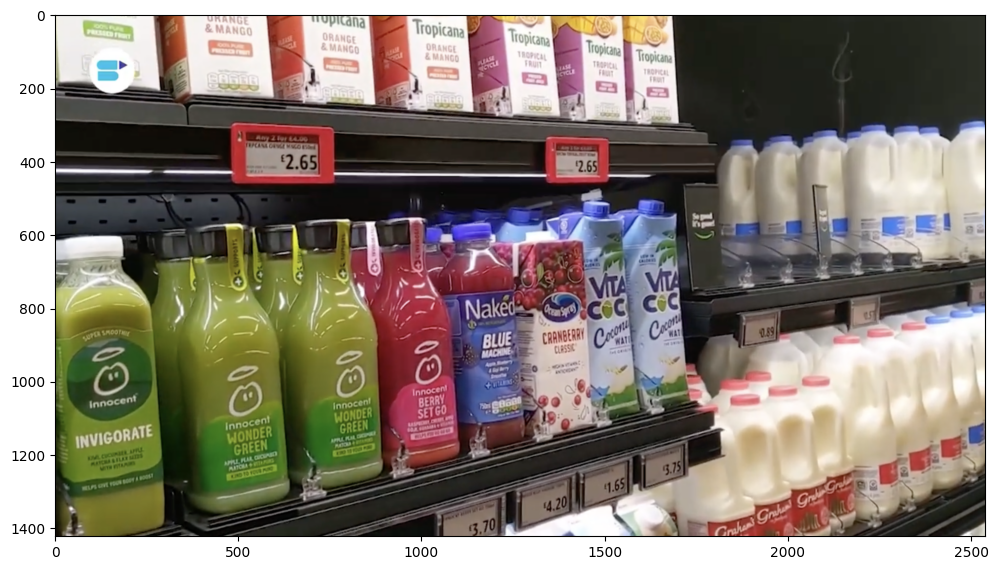

In [11]:
image = cv2.imread('./data/images/input/example/dairy_bottles.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.grid(False)
plt.imshow(image)
plt.show()

In [12]:
width, height = 640, 480
dfImage, resizedImage = utils.loadImageAndConvertToDataframe('./data/images/input/example/dairy_bottles.png', width, height)

### Run Inference

With that done, we can have the model detect the objects on the image by running an inference through the pipeline, and storing the results for the next step.

**IMPORTANT NOTE**:  If necessary, add `timeout=60` to the `infer` method if more time is needed to upload the data file for the inference request.

In [14]:
startTime = time.time()
infResults = pipeline.infer(dfImage, timeout=300)
endTime = time.time()
infResults.loc[:, ['time', 'out.boxes', 'out.classes', 'out.confidences', 'anomaly.count']]

,time,out.boxes,out.classes,out.confidences,anomaly.count
0,2025-01-02 21:18:51.889,"[2.1511102, 193.98326, 76.26535, 475.4029, 610.82245, 98.606316, 639.8868, 232.27054, 544.2867, 98.72652, 581.2884, 230.2049, 454.99344, 113.08567, 484.78464, 210.1282, 502.58884, 331.87665, 551.2269, 476.49182, 538.5426, 292.12054, 587.46545, 468.12885, 578.5417, 99.70756, 617.2247, 233.57082, 548.552, 191.84563, 577.3059, 238.4774, 459.83322, 344.29712, 505.42636, 456.7118, 483.47165, 110.565865, 514.0936, 205.00156, 262.1222, 190.36658, 323.4903, 405.20584, 511.6675, 104.53834, 547.01715, 228.23663, 75.39195, 205.62312, 168.49892, 453.44086, 362.50656, 173.16858, 398.66956, 371.8243, 490.42468, 337.627, 534.1234, 461.0242, 351.3856, 169.14899, 390.7583, 244.0699, 525.19824, 291.73898, 570.5553, 417.64383, 563.42236, 285.3889, 609.3085, 452.25943, 425.57935, 366.24915, 480.63535, 474.54, 154.538, 198.03773, 227.64284, 439.84418, 597.02893, 273.60455, 637.2067, 439.03207, 473.88763, 293.41992, 519.7537, 349.2304, 262.776, 192.03581, 313.30966, 258.3466, 521.1493, 152.89027, 534.8596, 246.52364, 389.89633, 178.07867, 431.87555, 360.59323, ...]","[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 86, 82, 44, 44, 44, 44, 44, 44, 84, 84, 44, 44, 44, 44, 86, 84, 44, 44, 44, 44, 44, 84, 44, 44, 84, 44, 44, 44, 44, 51, 44, 44, 44, 44, 44, 44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 86, 44, 44, 1, 84, 44, 44, 44, 44, 84, 47, 47, 84, 14, 44, 44, 53, 84, 47, 47, 44, 84, 44, 44, 82, 44, 44, 44]","[0.99653554, 0.98834026, 0.97002465, 0.9696426, 0.96478045, 0.9603756, 0.9542889, 0.9467542, 0.9465237, 0.94484967, 0.9361184, 0.91653466, 0.9133635, 0.8874812, 0.84405947, 0.82552624, 0.8232691, 0.8174005, 0.7956523, 0.7866909, 0.77314866, 0.7519366, 0.7360914, 0.7009186, 0.69323516, 0.65077263, 0.63243586, 0.57877654, 0.502348, 0.50163716, 0.44628552, 0.4280431, 0.42537966, 0.3908611, 0.36836445, 0.34732425, 0.32950592, 0.31053764, 0.29076266, 0.28558296, 0.26679984, 0.26302835, 0.2544436, 0.24568689, 0.23536606, 0.23321997, 0.22612895, 0.22483155, 0.22332445, 0.21442945, 0.2012232, 0.19754833, 0.19439253, 0.19083893, 0.18713802, 0.17646065, 0.16628972, 0.16326289, 0.14825195, 0.13694565, 0.12920663, 0.12815322, 0.12235797, 0.121289365, 0.11628052, 0.11498642, 0.1118483, 0.11016128, 0.109506026, 0.103915066, 0.10385671, 0.09757356, 0.096320525, 0.09557607, 0.091599174, 0.09061975, 0.082623556, 0.08223468, 0.0799393, 0.07989222, 0.0787584, 0.07820158, 0.07737942, 0.07690257, 0.07593438, 0.07503378, 0.07482609, 0.06898081, 0.06841153, 0.06764169, 0.06575063, 0.064908616, 0.061884128, 0.0601012, 0.05788715, 0.057176284, 0.05661627, 0.05601708, 0.054583292, 0.053669747]",0


### Draw the Inference Results

With our inference results, we can take them and use the Wallaroo CVDemo class and draw them onto the original image.  The bounding boxes and the confidence value will only be drawn on images where the model returned a 50% confidence rate in the object's identity.

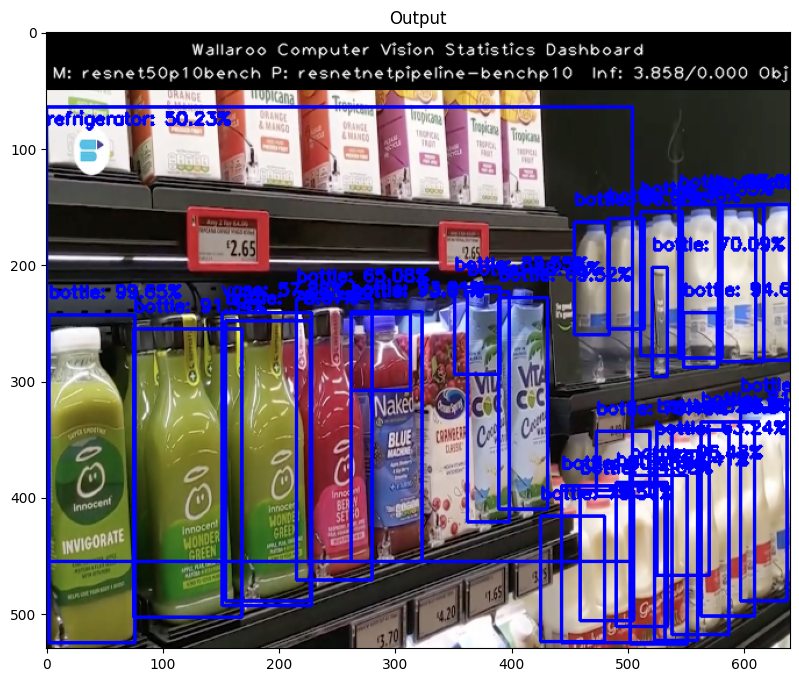

In [15]:
elapsed = 1.0
results = {
    'model_name' : model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : infResults,
    'confidence-target' : 0.50,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(elapsed) / 1e+9,
    'classes_file': "./models/coco_classes.pickle",                 
    'color': 'BLUE'
}

image = utils.drawDetectedObjectsFromInference(results)

### Undeploy the Pipeline

With the inference complete, we can undeploy the pipeline and return the resources back to the Wallaroo instance.

In [16]:
pipeline.undeploy()

name,resnetnetpipeline-benchp10
created,2025-05-13 19:00:34.872005+00:00
last_updated,2025-07-16 16:07:42.147051+00:00
deployed,False
workspace_id,1449
workspace_name,resnetworkspace
arch,power10
accel,none
tags,
versions,"0965bd81-bfa2-4bdb-935d-02d5ed3735d2, df96dd9d-6638-4349-a5aa-9f04967900ea, 617c2b4c-a504-48c0-81ca-863c8b565d1b, d07edbd9-ba5d-41b1-8c30-024b718d1938"
steps,resnet50p10bench


### Publish the Model

Publishing the model takes the model, pipeline, and Wallaroo engine and puts them into an OCI compliant registry for later deployment on Edge and multi-cloud environments.

Publishing the pipeline uses the pipeline `wallaroo.pipeline.Pipeline.publish()` command.  This requires that the Wallaroo Ops instance have [Edge Registry Services](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/#enable-wallaroo-edge-deployment-registry) enabled.

When publishing, we specify the pipeline deployment configuration through the `wallaroo.DeploymentConfigBuilder`.  For our example, we do **not** specify the architecture; the architecture and is inherited from the model.

The following publishes the pipeline to the OCI registry and displays the container details.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/).

In [17]:
pipeline.publish(deployment_config=deploy_config)

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is publishing....... Published.


ID,105
Pipeline Name,resnetnetpipeline-benchp10
Pipeline Version,f4c37196-0656-4471-b6b9-c5c3ea7bb16b
Status,Published
Workspace Id,1449
Workspace Name,resnetworkspace
Edges,
Engine URL,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini-ppc64le:v2025.1.0-6245
Pipeline URL,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/resnetnetpipeline-benchp10:f4c37196-0656-4471-b6b9-c5c3ea7bb16b
Helm Chart URL,oci://us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts/resnetnetpipeline-benchp10
Helm Chart Reference,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts@sha256:3ec939251f568c2f7bcff9f90315ce41e93f95012f6332cd9a1561ef8c576c34


### Edge Deployment

Included with the publish details include instructions on deploying the model via `Docker Run` and `Helm Install` commands with the defined deployment configuration on the Power10 architecture.

## Contact Us

For access to these sample models and for a demonstration:

* Contact your Wallaroo Support Representative **OR**
* [Schedule Your Wallaroo.AI Demo Today](https://wallaroo.ai/request-a-demo/)